In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


archive/.DS_Store
archive/data.csv
archive/real/real_298.jpg
archive/real/real_515.jpg
archive/real/real_273.jpg
archive/real/real_267.jpg
archive/real/real_501.jpg
archive/real/real_529.jpg
archive/real/real_85.jpg
archive/real/real_91.jpg
archive/real/real_105.jpg
archive/real/real_46.jpg
archive/real/real_52.jpg
archive/real/real_111.jpg
archive/real/real_139.jpg
archive/real/real_461.jpg
archive/real/real_307.jpg
archive/real/real_313.jpg
archive/real/real_475.jpg
archive/real/real_449.jpg
archive/real/real_448.jpg
archive/real/real_312.jpg
archive/real/real_474.jpg
archive/real/real_460.jpg
archive/real/real_306.jpg
archive/real/real_138.jpg
archive/real/real_53.jpg
archive/real/real_110.jpg
archive/real/real_104.jpg
archive/real/real_47.jpg
archive/real/real_90.jpg
archive/real/real_84.jpg
archive/real/real_528.jpg
archive/real/real_266.jpg
archive/real/real_500.jpg
archive/real/real_514.jpg
archive/real/real_272.jpg
archive/real/real_299.jpg
archive/real/real_502.jpg
archive/rea

In [2]:
import os
import random
import gc
import warnings
import itertools

import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split


In [3]:
data_df = pd.read_csv('archive/data.csv').sample(frac=1)

In [4]:
data_df.head()

,images_id,label
827,fake_313,fake
848,fake_332,fake
130,real_216,real
1115,fake_573,fake
729,fake_225,fake


In [5]:
data_df.isnull().sum()

images_id    0
label        0
dtype: int64

In [6]:
data_df['path'] = data_df['images_id'].apply(lambda x: os.path.join('archive/real', x+'.jpg') if x.startswith('real') else os.path.join('archive/fake', x+'.jpg'))
data_df['label'] = data_df['label'].map(lambda x: 1 if x == 'fake' else 0)


In [7]:
data_df.head()

,images_id,label,path
827,fake_313,1,archive/fake/fake_313.jpg
848,fake_332,1,archive/fake/fake_332.jpg
130,real_216,0,archive/real/real_216.jpg
1115,fake_573,1,archive/fake/fake_573.jpg
729,fake_225,1,archive/fake/fake_225.jpg


<BarContainer object of 2 artists>

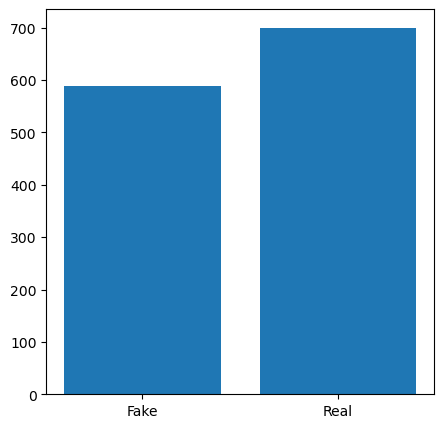

In [8]:
fig = plt.figure(figsize=(5,5))
plt.bar(data_df['label'].value_counts().index, data_df['label'].value_counts(), tick_label=['Real','Fake'])

In [9]:
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

In [10]:
print("train:", len(train_df))
print("validation:", len(val_df))
print("Test:", len(test_df))


train: 773
validation: 258
Test: 258


In [11]:
data_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.img_labels = dataframe['label']
        self.img_paths = dataframe['path']
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths.iloc[idx])
        label = self.img_labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Veri kümesine dönüşümleri uygulama
train_dataset = CustomImageDataset(train_df, transform=data_transforms)
val_dataset = CustomImageDataset(val_df, transform=data_transforms)
test_dataset = CustomImageDataset(test_df, transform=data_transforms)

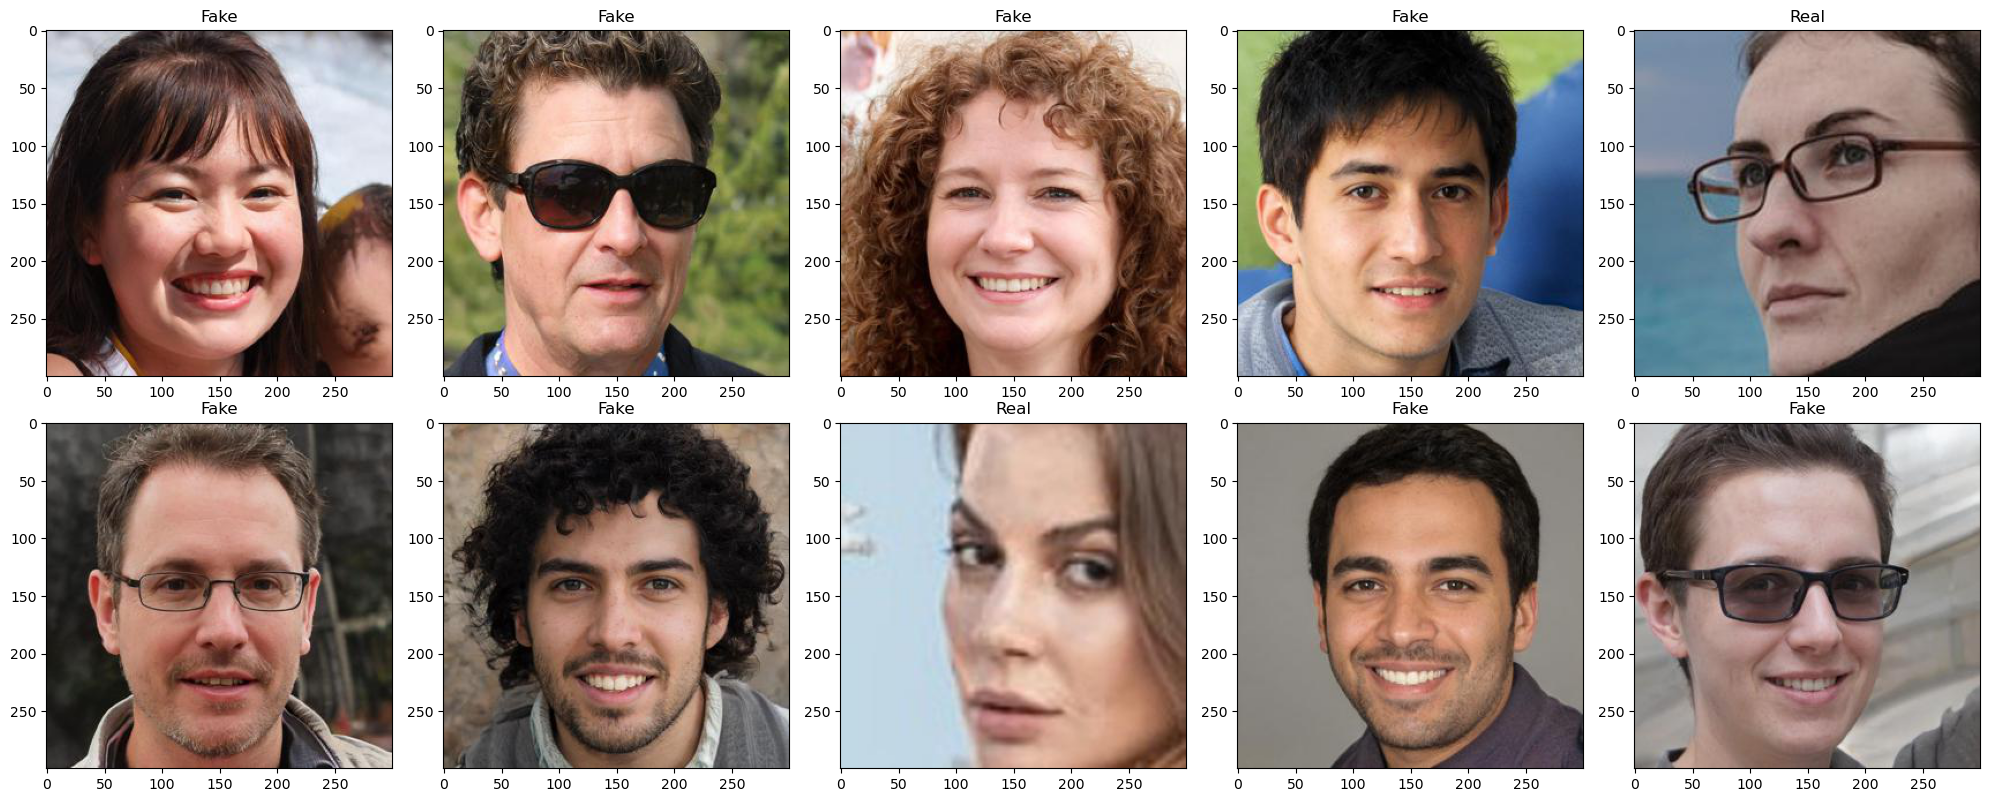

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Eğitim veri kümesinden birkaç örnek gösterme
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(2):
    for j in range(5):
        index = i * 5 + j
        img_path = train_df.iloc[index]['path']
        label = train_df.iloc[index]['label']
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title('Fake' if label == 1 else 'Real')
      

plt.tight_layout()
plt.show()

In [14]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models


pretrained_model = models.shufflenet_v2_x1_0(pretrained=True)


feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])


classifier_layers = nn.Sequential(
    nn.Flatten(),
    nn.Linear(50176, 128), 
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),
    nn.Sigmoid()
)


model = nn.Sequential(
    feature_extractor,
    classifier_layers
)


device = 'cpu'
model = model.to(device)


optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() 

sample_input = torch.randn(1, 3, 224, 224).to(device)
output = model(sample_input)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models


pretrained_shufflenet = models.shufflenet_v2_x1_0(pretrained=True)

pretrained_squeezenet = models.squeezenet1_1(pretrained=True)

shufflenet_features = nn.Sequential(*list(pretrained_shufflenet.children())[:-1])


squeezenet_features = nn.Sequential(
    *list(pretrained_squeezenet.features.children()),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(512, 1024)  
)


classifier_layers = nn.Sequential(
    nn.Linear(2048, 128),  
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),
    nn.Sigmoid()
)


class HybridModel(nn.Module):
    def __init__(self, shufflenet_features, squeezenet_features, classifier_layers):
        super(HybridModel, self).__init__()
        self.shufflenet_features = shufflenet_features
        self.squeezenet_features = squeezenet_features
        self.classifier_layers = classifier_layers

    def forward(self, x):
        shufflenet_output = self.shufflenet_features(x)
        squeezenet_output =self.squeezenet_features(x)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Training Loss: 0.2596, Training Accuracy: 0.8926, Validation Loss: 0.1885, Validation Accuracy: 0.9070
Epoch 2/20, Training Loss: 0.2276, Training Accuracy: 0.9069, Validation Loss: 0.1689, Validation Accuracy: 0.9264
Epoch 3/20, Training Loss: 0.1720, Training Accuracy: 0.9288, Validation Loss: 0.2537, Validation Accuracy: 0.9147
Epoch 4/20, Training Loss: 0.1538, Training Accuracy: 0.9314, Validation Loss: 0.1860, Validation Accuracy: 0.9031
Epoch 5/20, Training Loss: 0.1519, Training Accuracy: 0.9327, Validation Loss: 0.2388, Validation Accuracy: 0.9186
Epoch 6/20, Training Loss: 0.1663, Training Accuracy: 0.9444, Validation Loss: 0.1785, Validation Accuracy: 0.9186
Epoch 7/20, Training Loss: 0.1110, Training Accuracy: 0.9495, Validation Loss: 0.1624, Validation Accuracy: 0.9496
Epoch 8/20, Training Loss: 0.1075, Training Accuracy: 0.9508, Validation Loss: 0.1815, Validation Accuracy: 0.9264
Epoch 9/20, Training Loss: 0.1134, Training Accuracy: 0.9599, Validation Loss: 0

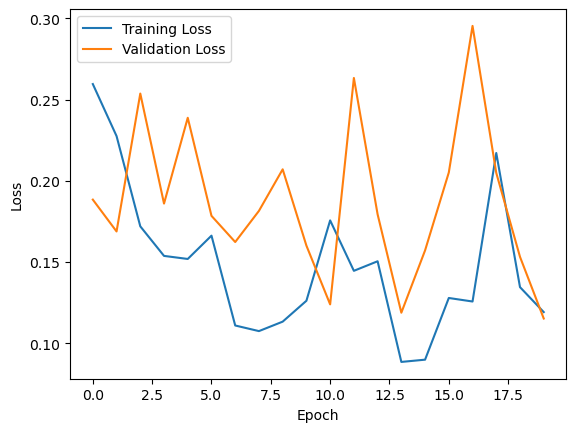

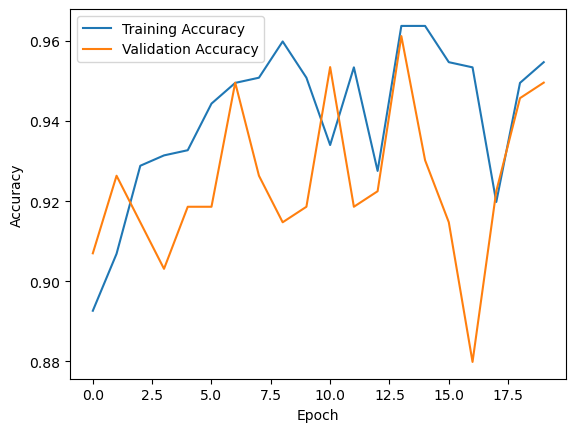

In [25]:
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            predicted = torch.round(outputs)
            total_train += labels.size(0)
            correct_train += (predicted == labels.unsqueeze(1)).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                val_loss += loss.item() * inputs.size(0)
                predicted = torch.round(outputs)
                total_val += labels.size(0)
                correct_val += (predicted == labels.unsqueeze(1)).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Training Loss: {epoch_loss:.4f}, "
              f"Training Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}")

    # Plot losses
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Train and validate the model
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20)

In [27]:
import torch
from torchvision.transforms import functional as TF
import numpy as np

In [29]:
torch.save(model.state_dict(), 'v2_2011.pth')
print("Model weights saved successfully!")

Model weights saved successfully!


In [6]:
import torch
from torchvision.transforms import functional as TF
import gradio as gr
import torchvision.models as models
import torch.nn as nn

# Load the model and weights
weights_path = 'v2_2011.pth'  # Update this with your actual path

# Ensure the model architecture matches the one used during training
device = torch.device('cpu')  # Use 'cuda' if GPU is available and required

# Define your model architecture (ensure it matches the trained model)
pretrained_model = models.shufflenet_v2_x1_0(weights="DEFAULT")
feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])

classifier_layers = nn.Sequential(
    nn.Flatten(),
    nn.Linear(50176, 128), 
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),
    nn.Sigmoid()
)

model = nn.Sequential(
    feature_extractor,
    classifier_layers
)

# Load weights
model.load_state_dict(torch.load(weights_path, map_location=device))
model.to(device)
model.eval()

# Prediction function
def predict_image(image):
    # Resize and preprocess the image
    image = TF.resize(image, (224, 224))  # Resize the image to 224x224
    image_tensor = TF.to_tensor(image).unsqueeze(0).to(device)  # Add batch dimension
    image_tensor = TF.normalize(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize

    with torch.no_grad():
        prediction = model(image_tensor).item()  # Get the scalar output

    confidence = prediction * 100
    label = "Fake" if prediction >= 0.5 else "Real"

    return f"{label} "

# Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Deepfake Detection",
    description="Upload an image to determine if it's 'Real' or 'Fake' with confidence percentage."
)

# Launch the interface
interface.launch(share=True)

/var/folders/xc/6v63mh_92hv2b9by85_fmb5r0000gn/T/ipykernel_4296/3990440257.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://e36959b177843be657.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [67]:
def predict_image(image):
    weights_path = 'v2_2011.pth'
    model.load_state_dict(torch.load(weights_path))
    weights_only=True

    model.eval()  # Set the model to evaluation mode

    # Resize and preprocess the image
    image = TF.resize(image, (224,224))  # Resize the image
    image_tensor = TF.to_tensor(image)  # Convert to tensor
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor / 255.0  # Normalize the image

    # Make predictions
    with torch.no_grad():  # Disable gradient calculations
        prediction = model(image_tensor).item()  # Get the

    # image = image.resize((300, 300))

    # image_array = img_to_array(image) / 255.0

    # image_array = np.expand_dims(image_array, axis=0)

    # prediction = model.predict(image_array)[0][0]

    confidence = prediction * 100

    label = "Real" if prediction >= 0.5 else "Fake"

    return f"{label} ({confidence:.2f}%)"

In [69]:
import gradio as gr

In [71]:
interface = gr.Interface(
    fn = predict_image,
    inputs = gr.Image(type = "pil"),
    outputs = "text",
    title = "Deepfake Detection (Team 14)",
    description = "Upload an image to determine if it is 'Real' or 'Fake' with confidence percentage."
)

In [73]:
interface.launch(debug=True)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


/var/folders/xc/6v63mh_92hv2b9by85_fmb5r0000gn/T/ipykernel_52717/1652102217.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path

Keyboard interruption in main thread... closing server.
